## 2-Qubit Boltzmann Machine

We use a 2-qubit system, where the goal is to learn the parameters of the Ising Hamiltonian:

$H = \sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_0^k \otimes \sigma_1^{k'} + h^k_0 \sigma_0^k + h^{k'}_1 \sigma_1^{k'} $

where $w_{ij}^{kk'}$ is the coupling strength, $h_i$ are the local fields, and $\sigma_i^k$ are the Pauli operators. For the Pauli matrices, indexes $k=1,2,3$ correspond to $x,y,z$, index $k=0$ to the identity. The explicit Hamiltonian is written as:

$H = \sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_0^k \otimes \sigma_1^{k'} + h^k_0 \sigma_0^k \otimes \sigma_1^0 + h^{k'}_1 \sigma_0^0 \otimes \sigma_1^{k'}$


The parameter matrix "w" is written in the Z-basis. It will have all zeros in column 2 and row 2, except for the diagonal term "h". The row index corresponds to spin 0 and the column to spin 1.

* $w[0,k] = h_1^k$ is the external field on spin $1$; $k = 1,2,3$
* $w[k,0] = h_0^k$ is the external field on spin $0$; $k = 1,2,3$
* $w[0,0] = -\log Z$

For the external field, $h_0$ and $h_1$ both have a zero in its y-component ($h_0[1] = h_1[1] = 0$)

A vector state follows the numbering convention $|s_0, \dots, s_n>$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from numba import njit

In [2]:
@njit
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector)
        res += np.log(evals[i]) * projector
    return res

def generate_interaction_matrices():
    """
    Constructs the tensor product of Pauli matrices for each spin and 
    uses them to build the interaction matrices between the two spins.
    """
    pauI = np.array([[1,0],[0,1]],np.complex64)
    pauX = np.array([[0,1],[1,0]],np.complex64)
    pauY = np.array([[0,-1j],[1j,0]],np.complex64)
    pauZ = np.array([[1,0],[0,-1]],np.complex64)
    pau = np.array([pauI, pauX, pauY, pauZ], dtype=np.complex64)

    interactions = np.zeros((4, 4, 4, 4), dtype=np.complex64)
    for k in range(4):
        for kprime in range(4):
            interactions[k, kprime] = np.kron(pau[k], pau[kprime])
    return interactions


@njit
def hamiltonian2spins(w,interactions):
    """
    Calculates the Hamiltonian matrix of a two-spin system 
    """
    H = np.zeros((4,4),np.complex64)
    for k in range(4):
        for kprime in range(4):
            H += w[k,kprime] * interactions[k,kprime]
    return H

@njit
def rho_model(w,interactions):
    """
    Computes the density matrix of a two-spin system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H      = hamiltonian2spins(w,interactions)        #  get hamiltonian matrix
    rho    = expmat(H)                                #  defintion of rho
    Z      = np.real(np.trace(rho))                   #  get Z
    rho   /= Z                                        #  normalize such that Tr[rho] = 1
    return rho

@njit
def observables(rho, interactions):
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros((4,4))
    for k in range(4):
        for kprime in range(4):
            obs[k,kprime] = np.real(np.trace(rho@interactions[k,kprime]))
    return obs

@njit
def KL_divergence(eta,rho):
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

In [3]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, size=10):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=size, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yscale('log')

def plot(it, KL, Wmax, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(25, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 2, 1)
    plot_scatter(ax1, its, Wmax[:it], "Iterations", r"$ (\Delta W)_{max}$", "Coral", size)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
   
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(its, KL[:it], s=size, marker='o', color="ForestGreen")
    ax2.set_xlabel("Iterations", fontsize=20)
    ax2.set_ylabel("KL Divergence", fontsize=20)
    ax2.set_ylim([-0.1,0.02])
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

In [4]:
@njit
def generate_obs(w, interactions):
    rho  = rho_model(w, interactions)         # compute density matrix using ED
    obs  = observables(rho, interactions)     # get QM statistics  
    return rho, obs

@njit
def generate_w():
    w = np.random.randn(4, 4)         # get normal distributed weights
    w[0, 0] = 0
    return w

@njit
def learn_w(interactions, lr, maxiter, tol):
    """
    Train the model to fit the target distribution eta
    """
    
    w_eta            = generate_w()                #  get clamped QM statistics
    eta, obs_clamped = generate_obs(w_eta, interactions)
    
    w                = generate_w()                #  get free QM statistics 
    rho, obs_model   = generate_obs(w, interactions)     
    
    it = 0                                                 #  initialize gradient ascent loop
    diff = np.max(np.abs(obs_model-obs_clamped))
    Wmax_list = np.zeros(maxiter)                          #  initialize values to store
    KL_list   = np.zeros(maxiter)
    
    
    while (diff > tol and it < maxiter): 
        rho, obs_model  = generate_obs(w, interactions)    #  get free QM statistics
        w              += lr * (obs_clamped -  obs_model)  #  update weights
        
        diff = np.max(np.abs(obs_model-obs_clamped))       #  evaluate differences in clamped and model statistics        
        Wmax = np.max(np.abs(w-w_eta))
        
        Wmax_list[it] = Wmax                               #  store values
        KL_list[it]   = KL_divergence(eta,rho)
        it += 1 
    return w, w_eta, KL_list, Wmax_list, it

In [5]:
#learning parameters
lr       = 1.2      #  learning rate 
maxiter  = 2**16    #  iterations
tol      = 1e-10    #  tolerance

interactions     = generate_interaction_matrices()     #  generate interaction matrices

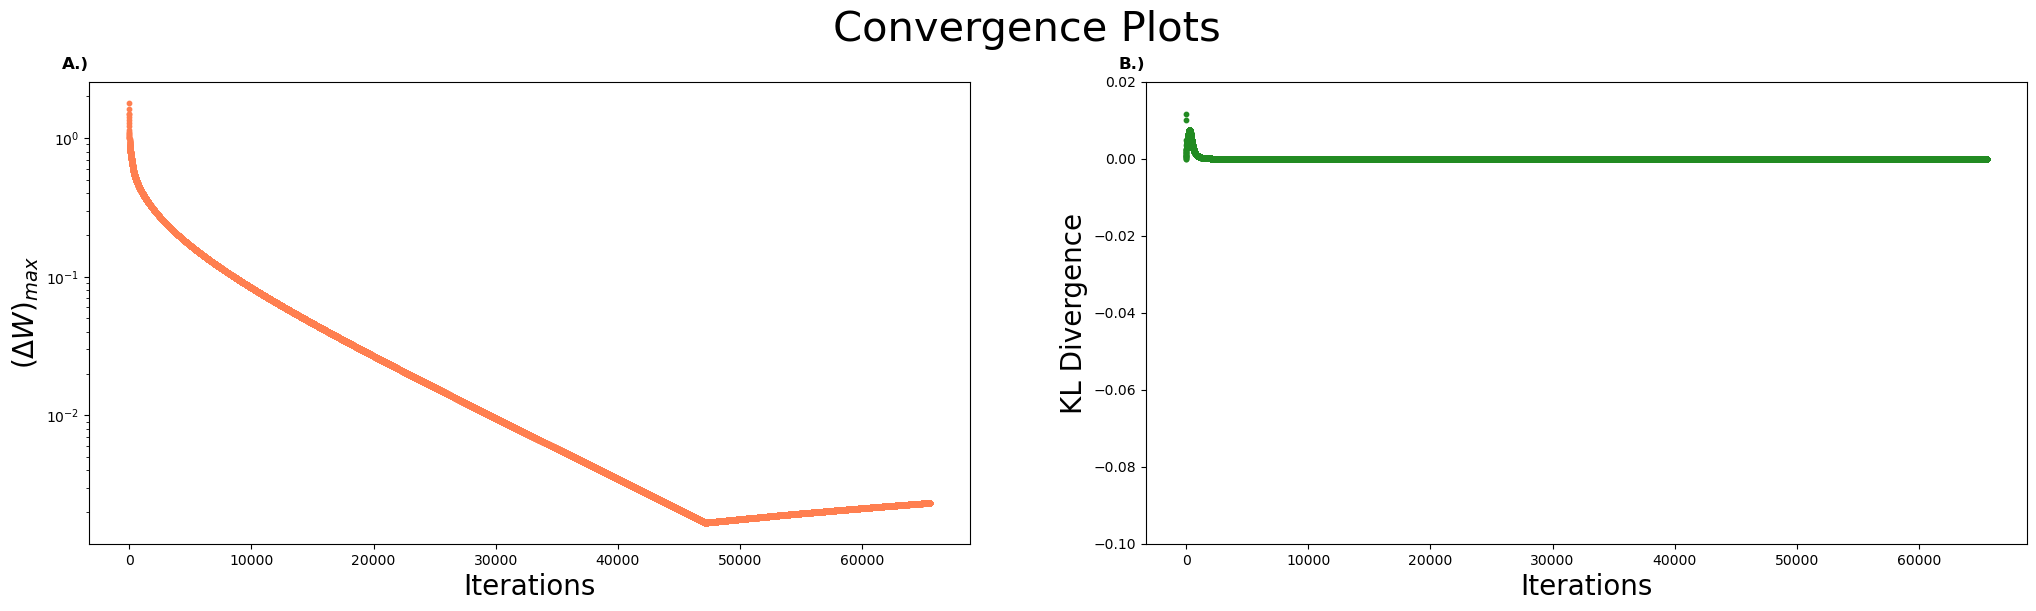

In [6]:
w, w_eta, KL, Wmax, it = learn_w(interactions, lr, maxiter, tol)
plot(it, KL, Wmax, title='Convergence Plots', size=10)
plt.savefig('Figures/2 Qubit QBM/convergence', bbox_inches='tight')

In [8]:
np.set_printoptions(formatter={'float_kind':"{:.6f}".format}) # print matrices in 2 decimals
#np.set_printoptions(formatter={'complex_kind': lambda x: "{:.2f}+{:.2f}j".format(x.real, x.imag)})

print(np.abs(w-w_eta))

[[0.000015 0.000003 0.000007 0.000003]
 [0.000007 0.000003 0.000006 0.000002]
 [0.000003 0.000001 0.000002 0.000003]
 [0.000001 0.000003 0.000000 0.000000]]


In [ ]:
def generate_w(wx1x2, wy1y2, w1z2z, hx1, hx2, hy1, hy2, hz1, hz2):
    return np.array([
        [0,  hx2, hy2, hz2],
        [hx1, wx1x2, 0,  0],
        [hy1, 0,  wy1y2, 0],
        [hz1, 0,  0,  w1z2z]
    ])

#interaction parameters
wx1x2 = 0
wy1y2 = 0
wz1z2 = 2
hx1   = 0
hx2   = 0
hy1   = 0
hy2   = 0
hz1   = 1
hz2   = 1
    
w = generate_w(wx1x2 ,wy1y2, wz1z2, hx1, hx2, hy1, hy2, hz1, hz2)